# Machine Learning Project
## Prediction of End-tidal Sevoflurane Gas Concentration of Patient During Surgery
In this project the current time (t) exhaled sevoflurane gas concentration is predicted based on features from the previous second (t-1) using the models:

* Multivariate Time Series Forecasting with Long Short-Term Memory (LSTM) Recurrent Neural Network
* Regular Multivariate Linear Regression

The Machine Learning Group at the Universit&#0233; Libre de Bruxelles has conducted [research](https://www.researchgate.net/publication/264839503_Real-time_prediction_of_an_anesthetic_monitor_index_using_machine_learning) on predicting the bispectral index (BIS) which is derived from an electroencephalogram. This is essentially a dimensionless quantity that determines the "level of awareness" of a patient. They were able to successfully predict the BIS and were deemed "suﬃciently close". However, this projects attempts to directly predict the amount of anesthesia exhaled to give the anesthesiologist more information on what the concentration should be based on the measured features one second ago. This provides a self-evaluation tool for how much anesthesia should be added at a given time.

The data is pulled from the [University of Queensland Vital Signs Dataset](http://dx.doi.org/102.100.100/6914), which contains 32 surgical cases of patients that underwent anesthesia at Royal Adelaide Hospital. Several vital signs were recorded during each surgery with 65+ [parameters](https://outbox.eait.uq.edu.au/uqdliu3/uqvitalsignsdataset/parameters.html). However, only the following parameters were used along with their units:
* Heart Rate (bpm)
* Blood Oxygen Saturation (%)
* Mean Blood Pressure (mm Hg)
* End-tidal CO2 (mm Hg)
* Respiratory Rate (breaths per minute)
* Insipred oxygen concentration (%)
* Inspired sevoflurane gas concentration (%)
* End-tidal sevoflurane gas concentration (%)

First, the database needs to be downloaded to a folder names 'Cases', with subfolders named 'case##'. In each case folder, there is a folder named 'fulldata' which consists of a list of csv files. Therefore, for each case loaded, there must be a loop that appends all of the csv files. The following function implements this and returns a numpy martrix X of all the desired features mentioned above.

The sampling time is 10 ms for every case. The data is downsampled to 1 second, such that there is one sample per second only (every 100th sample is taken). This is done to decrease the amount of samples, and is more reasonable for an anesthesiologist to see the predicted sevoflurane to update every second instead of 10 ms.


In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from os import listdir

# Function to load in data
def load_data(casenum):
    # Create a pandas dataframe
    df = pd.DataFrame()
    
    # The desired features as mentioned above
    cols = [3, 6, 8, 13, 23, 24, 29, 36]
    
    # Convert the case number to a string and pad zeros if needed
    casenum = str(casenum).zfill(2)

    # List of files for a case number
    files = [f for f in listdir('Cases/case' + casenum + '/fulldata')]
    
    # Append files into one dataframe
    for f in files:
        # Read in file and append
        df = df.append(pd.read_csv('Cases/case' + casenum + '/fulldata/' + f,index_col=False, usecols=cols))
        
        # Replace NaN values with zero
        df = df.fillna(0)
    
    # Only take every 100th sample
    X = np.array(df)[::100,:]
    return X, df

# Desired case to analyze
casenum = 1

# Load in data
X, df = load_data(casenum)

print('The shape of full data frame: {0}'.format(df.shape))
print('The shape of downsampled data: {0}'.format(X.shape))

# Show first 5 rows of data frame before downsampling
df.head()

The shape of full data frame: (729600, 8)
The shape of downsampled data: (7296, 8)


,HR,SpO2,etCO2,NBP (Mean),etSEV,inSEV,inO2,RR
0,55.0,100.0,0,0.0,0.0,0.0,98,0
1,55.0,100.0,0,0.0,0.0,0.0,98,0
2,55.0,100.0,0,0.0,0.0,0.0,98,0
3,55.0,100.0,0,0.0,0.0,0.0,98,0
4,55.0,100.0,0,0.0,0.0,0.0,98,0


Here the inspired sevoflurane gas concentration and end-tidal sevoflurane gas concentration is shown on the same plot for case 1.

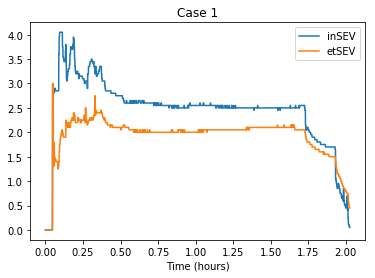

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the inhaled and exhaled sevoflurane
t = np.arange(X.shape[0]) / 60 / 60  # Time in hours
plt.plot(t, X[:,5], label = 'inSEV')
plt.plot(t, X[:,4], label = 'etSEV')
plt.xlabel('Time (hours)')
plt.title('Case {0}'.format(casenum))
plt.legend()

## Modeling with Multivariate LSTM
The Long Short-Term Memory network is a type of Recurrent Neural Network that is designed to learn long-term dependencies. This is useful for the data since it spans hours of information on the resolution of seconds or even milliseconds. The fact that the model can learn and remember over long sequences should be able to provide high accuracy for predicting sevoflurane throughout the surgery.

Jason Brownlee's [tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) on using LSTMs is well written, and was used to implement some of the preprocessing and modeling for LSTM.

The following function is used from his tutorial which implements the the necessary preprocessing. Using the sklearn libray's function MinMaxScaler, the data was normalized to a value between 0 and 1. Then all the features were delayed by one sample which in this case is one second. The new supervised learning reframed matrix is then modified to drop the current time variables, except for the desired target variable of etSEV. The final matrix consists of the previous time of all features, and the current time of etSEV at the end.

In [3]:
from sklearn.preprocessing import MinMaxScaler 

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequency (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    
# Ensure all data is float
X = X.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(X)

# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,13,14,15]], axis = 1, inplace = True)

print('The new shape of the data is: {0}'.format(reframed.shape))

# First five rows of new data matrix
reframed.head()

The new shape of the data is: (7295, 9)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var5(t)
1,0.753425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.753425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.753425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.753425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.753425,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The first 30 minutes (1800 seconds) of the surgery will be used as the training samples. The idea is to have an anesthesiologist let the system 'calibrate' or train itself on the current patient for the first 30 minutes of surgery. Then the rest of the surgery it would attempt to predict the etSEVO. The rest of the surgery is used as the test points to evaluate the accuracy.

In addition, the LSTM model expects a 3D input array or tensor. Each index is [samples, timesteps, features]. Here the timestep is set as 1, so each timestep is one sample from every feature.

In [4]:
# Get values from the dataframe
values = reframed.values

# Only first half hour (in seconds)
ntrain = 1800

# Split data into train and test sets
train = values[:ntrain, :]
test = values[ntrain:, :]

# Split data into input and output
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X_3D = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_3D = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X_3D.shape, train_y.shape, test_X_3D.shape, test_y.shape )

(1800, 1, 8) (1800,) (5495, 1, 8) (5495,)


In order to implement the neural network, the Keras package is used with a backend mathematicala library of TensorFlow to compile the model. The proposed model will contain:
* 100 neurons or hidden units
* 1 output neuron
* A loss function of mean squared error for regression
* The efficient optimizer 'ADAM'
* 50 epochs
* Batch size of 10

The shuffle was also set to false to allow the network to build up states as it learns across the sequence of observations.

In [5]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, LSTM

import keras.backend as K
K.clear_session()

# Design Network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X_3D.shape[1], train_X_3D.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Print Model Summary
model.summary()

# Fit Network
history = model.fit(train_X_3D, train_y, epochs=50, batch_size=10, validation_data=(test_X_3D, test_y), verbose=2, shuffle=False)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________
Train on 1800 samples, validate on 5495 samples
Epoch 1/50
 - 2s - loss: 0.0173 - val_loss: 0.0089
Epoch 2/50
 - 2s - loss: 0.0222 - val_loss: 0.0029
Epoch 3/50
 - 1s - loss: 0.0092 - val_loss: 0.0011
Epoch 4/50
 - 1s - loss: 0.0044 - val_loss: 8.3383e-04
Epoch 5/50
 - 1s - loss: 0.0032 - val_loss: 8.9384e-04
Epoch 6/50
 - 1s - loss: 0.0029 - val_loss: 9.2506e-04
Epoch 7/50
 - 1s - loss: 0.0027 - val_loss: 8.7525e-04
Epoch 8/50
 - 1s - loss: 0.0026 - val_loss: 7.8307e-04
Epoch 9/50
 - 1s - loss: 0.0024 - val_loss: 6.8752e-04
Epo

Both the training and test loss during training was tracked by setting the validation_data argument in the fit() function. Below is the plot of both losses after every epoch.

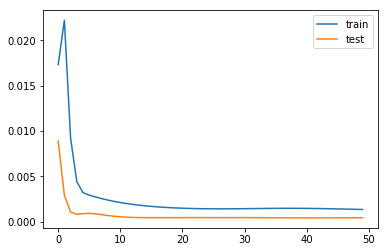

In [6]:
# Plot History
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Next, the model is evaluated to get a predicted yhat. The normalized residual sum of squares is evaluated to determine a consistent metric to compare between other cases later and even models. The normalized RSS is evaluated as follows:
$$
    \frac{RSS}{n s^2_y}
$$
This value is also useful because it can determine how strong the correlation is between the predicted and actual target variable:
$$
    R^2 = 1 - \frac{RSS}{n s^2_y}
$$

In [7]:
# Evaluate Model
yhat = model.predict(test_X_3D)

# Match shape of test y to yhat
test_y = test_y.reshape((len(test_y), 1))

# Calculate normalized RSS
RSS_test_normal = np.mean((yhat-test_y)**2)/(np.std(test_y)**2)

print('Normalized RSS test: {0}'.format(RSS_test_normal))
print('R^2: {0}'.format(1 - RSS_test_normal))

Normalized RSS test: 0.04263351323341189
R^2: 0.9573664867665881


Next, the actual exhaled sevoflurane is plotted with the predicted sevoflurane. The plot starts 30 minutes into the surgery, since the first half hour was used to train the model. The above correlation is pretty good for the simple features and model complexity used. In the plot it can be seen that the predicted sevoflurane concentration tracks the actual reliably.

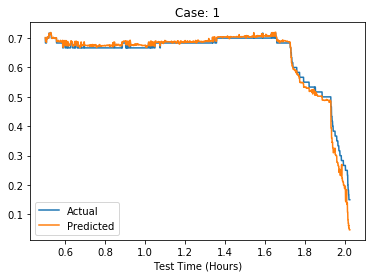

In [8]:
# Time vector
t = np.arange(values.shape[0])[ntrain:] / 60 / 60 # in hours

# Plot the actual and predicted sevoflurane
plt.plot(t, test_y, label = 'Actual')
plt.plot(t, yhat, label = 'Predicted')
plt.xlabel('Test Time (Hours)')
plt.title('Case: {0}'.format(casenum))
plt.legend(loc = 'lower left')

In order to check if there are consistent results between different patients and surgery lengths, the following loop repeats the analysis up until this point for cases 3, 4, and 5.

Case 3: RSS = 0.014006917643799549, R^2 = 0.9859930823562004
Case 4: RSS = 0.010017335187321761, R^2 = 0.9899826648126783
Case 5: RSS = 0.06958626354793095, R^2 = 0.930413736452069


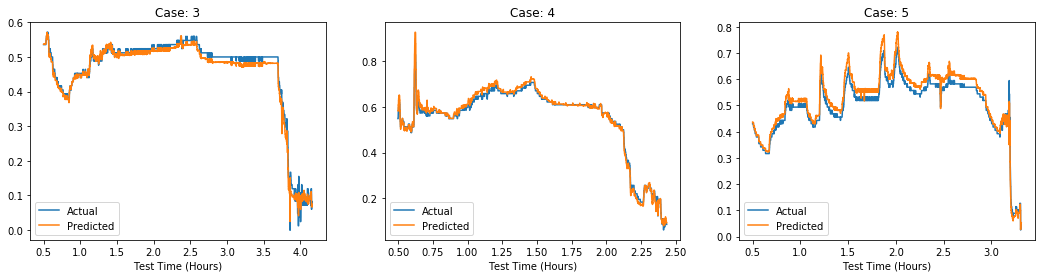

In [9]:
cases = [3, 4, 5]
plt.figure(figsize=(18, 4))

for i, case in enumerate(cases):
    # Load in, scale, and shift the data
    X, df = load_data(case)
    X = X.astype('float32')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(X)
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[8,9,10,11,13,14,15]], axis = 1, inplace = True)
    
    # Get values from the dataframe
    values = reframed.values

    # Only first half hour (in seconds)
    ntrain = 1800
    
    # Split data into train and test sets
    train = values[:ntrain, :]
    test = values[ntrain:, :]

    # Split data input and output
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # Reshape input to be 3D [samples, timesteps, features]
    train_X_3D = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_3D = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Clear Keras session
    K.clear_session()

    # Design Network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X_3D.shape[1], train_X_3D.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # Fit Network
    history = model.fit(train_X_3D, train_y, epochs=50, batch_size=10, validation_data=(test_X_3D, test_y), verbose=0, shuffle=False)

    # Make a prediction
    yhat = model.predict(test_X_3D)

    # Match shape of test y to yhat
    test_y = test_y.reshape((len(test_y), 1))
    
    # Calculate normalized RSS
    RSS_test_normal = np.mean((yhat-test_y)**2)/(np.std(test_y)**2)
    print('Case {0}: RSS = {1}, R^2 = {2}'.format(case , RSS_test_normal, 1-RSS_test_normal ))
    
    # Time vector
    t = np.arange(values.shape[0])[ntrain:] / 60 / 60 # in hours
    
    # Plot actual and predicted sevoflurane
    plt.subplot(1,3,i+1)
    plt.plot(t, test_y,label='Actual')
    plt.plot(t, yhat,label='Predicted')
    plt.legend(loc = 'lower left')
    plt.xlabel('Test Time (Hours)')
    plt.title('Case: {0}'.format(case))

# Modeling with Linear Regression
The RSS and correlation numbers achieved were very high for the LSTM model. However, it is complicated model to implement and perhaps the same can be achieved with similar or better results via linear regression. Since the algorithm is being applied to a medical context, it is always important to consider what can provide the best correlation (or accuracy if classification) possible. Here the regression is fitted and evaluated with the sklearn package by creating a LinearRegression class called regr.

In [10]:
# Replace the train and test X matrices to be the original 2 dimensional arrays
train_X = train[:, :-1]
test_X = test[:, :-1]

Normalized RSS test: 0.003797604129819805
R^2: 0.9962023958701802


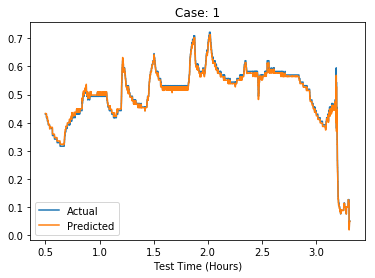

In [11]:
from sklearn import linear_model

# Create LinearRegression class and fit model with training data
regr = linear_model.LinearRegression()
regr.fit(train_X,train_y)

# Predict output based on test data
yhat_linear = regr.predict(test_X)

# Match shape of yhat to test y
yhat_linear = yhat_linear.reshape((len(yhat_linear), 1))

# Time vector
t = np.arange(1, X.shape[0])[ntrain:] / 60 / 60 # in hours
    
# Plot the actual and predicted sevoflurane
plt.plot(t, test_y,label='Actual')
plt.plot(t, yhat_linear,label='Predicted')
plt.xlabel('Test Time (Hours)')
plt.title('Case: {0}'.format(casenum))
plt.legend(loc = 'lower left')

# Calculate normalized RSS
RSS_test_normal = np.mean((yhat_linear-test_y)**2)/(np.std(test_y)**2)

print('Normalized RSS test: {0}'.format(RSS_test_normal))
print('R^2: {0}'.format(1 - RSS_test_normal))

According to the above RSS and figure, linear regression demonstrates a strong correlation between the actual and predicted exhaled sevoflurane. Next, linear regression is applied to cases 3, 4, and 5 to see how consistent the results are.

Case 3: RSS = 0.0025028639495789638, R^2 = 0.997497136050421
Case 4: RSS = 0.0018833274370168207, R^2 = 0.9981166725629832
Case 5: RSS = 0.003797604129819805, R^2 = 0.9962023958701802


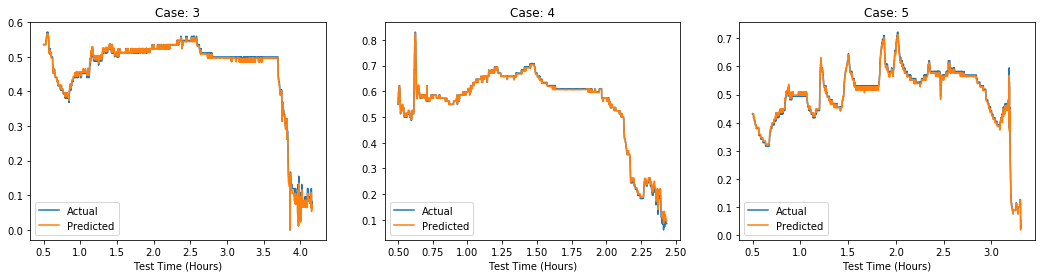

In [12]:
cases = [3, 4, 5]
plt.figure(figsize=(18, 4))

for i, case in enumerate(cases):
    # Load in, scale, and shift the data
    X, df = load_data(case)
    X = X.astype('float32')
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(X)
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[8,9,10,11,13,14,15]], axis = 1, inplace = True)
    
    # Get values from the dataframe
    values = reframed.values

    # Only first half hour (in seconds)
    ntrain = 1800

    # Split data into train and test sets
    train = values[:ntrain, :]
    test = values[ntrain:, :]

    # Split data input and output
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # Create LinearRegression class and fit model with training data
    regr = linear_model.LinearRegression()
    regr.fit(train_X,train_y)
    
    # Predict output based on test data
    yhat_linear = regr.predict(test_X)

    # Calculate normalized RSS
    RSS_test_normal = np.mean((yhat_linear-test_y)**2)/(np.std(test_y)**2)
    print('Case {0}: RSS = {1}, R^2 = {2}'.format(case , RSS_test_normal, 1-RSS_test_normal ))
    
    # Time vector
    t = np.arange(1, X.shape[0])[ntrain:] / 60 / 60 # in hours
    
    # Plot the actual and predicted sevoflurane
    plt.subplot(1,3,i+1)
    plt.plot(t, test_y,label='Actual')
    plt.plot(t, yhat_linear,label='Predicted')
    plt.legend(loc = 'lower left')
    plt.xlabel('Test Time (Hours)')
    plt.title('Case: {0}'.format(case))

It seems like the relationship between the current time of end-tidal sevoflurane to the given features a second ago is consistently linear. The three cases above all have a correlation that is almost 1 which is an improvement from the LSTM model. Perhaps the LSTM model was too complex for dataset and when there was noise or large variance in the data, it was more difficult to track.